#  Text Analytics (Unsupervised Clustering) and Neural Network Modelling

The following Jupyter Notebook provides steps to pre-process and model unlabelled social media conversastion data (text), and finaly build a Neural Network to predict labels.

The purpose of this pipeline is to create a **Labelled Dataset** from **Unlabelled unstructured data** using a combination of tradtional unsupervised clustering techniques.

## Contents
- ### [Housekeeping](#part_housekeeping)
- ### [Data Importing](#part_data_import)
- ### [Data Pre-Processing](#part_pre_processing)
- ### [Clustering](#part_clustering)
- ### [Manual Labelling](#part_labelling)
- ### [Modelling](#part_modelling)

## =========================================================================
## =========================================================================


<a id='part_housekeeping'></a>

# Part 0. Libraries / Routines / Environment 

Add all required libraries first.

## Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import nltk
from nltk.corpus import wordnet
from langdetect import detect
from langdetect import detect_langs
from sklearn.decomposition import TruncatedSVD
import pickle
from os.path import isfile, join


#for vectorizing
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn import feature_extraction
import re
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

#for modelling
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



#comment this out if you're not able to view any of the print lines
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

## Environment Variables

In [2]:
PATH = './'
PATH_TMP_DATA = './tmp_data/'

## Reusable Routines

In [3]:
def save_object(path, filename, obj):
    print('Saving Object')
    path_file = join(path, filename)    
    pickle.dump(obj, open(path_file, 'wb'))
    print('Save complete')

def load_object(path, filename):
    print('Attempting to Load Object')
    path_file = join(path, filename)    
    obj = pickle.load(open(path_file, "rb" ))
    print('Load complete')
    return obj


def save_csv(path, filename, dataframe):
    print('Saving Dataframe to CSV')
    path_file = join(path, filename)    
    dataframe.to_csv(path_file, index=False)

def load_csv(path, filename):
    print('Loading Dataframe From CSV')
    path_file = join(path, filename)
    dataframe = pd.read_csv(path_file)
    return dataframe        

## =========================================================================
## =========================================================================

<a id='part_data_import'></a>

# Part 1. Data Importing

In the following section we will import and inspect the data before working with it.

## Load the Data

In [4]:
def import_data(path_filename):
    """
    Imports data from a given path/filename
    """
    data_df = pd.read_csv(path_filename)# names = column_names)
    print('Total Rows:',data_df.shape[0])
    return data_df

data_df = import_data('celcom_processed_chat_data_customer_only_no_labels.csv')

Total Rows: 423830


C:\Users\ratinati\AppData\Local\Continuum\anaconda2\envs\gpu-tf\lib\site-packages\IPython\core\interactiveshell.py:2827: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Inspect the data 

In [5]:
def inspect_data(data_df):
    """
    Provides a short description of a dataframe
    """
    print(data_df.head(5))
    print(data_df.describe())
    
inspect_data(data_df)


   Unnamed: 0                             conId  \
0           0  0006f5ebe3eddaad5cabeed378c3d832   
1           1  0006f5ebe3eddaad5cabeed378c3d832   
2           2  001d06646b7e22ababdc5d3f0c9aca1a   
3           3  0020cf79b3afb07ff51986c04577dc39   
4           4  0020cf79b3afb07ff51986c04577dc39   

                                             message  
0  "Hi saya mendapat sms daripada pihak Celcom ya...  
1                                        Ok baik lah  
2  My no 0187777773 was being charged by Singtel-...  
3  Hi Celcom my service number is 0192662694. How...  
4  Hi Celcom my name is Low Ming Wee and last 4 d...  
          Unnamed: 0
count  423830.000000
mean   211914.500000
std    122349.326633
min         0.000000
25%    105957.250000
50%    211914.500000
75%    317871.750000
max    423829.000000


## =========================================================================
## =========================================================================

<a id='part_pre_processing'></a>


# Part 2. Data Pre-Processing

## Clean Data

The following code will clean the data to ensure there are no rows which contain text which is not suitable for the clustering or modelling.

In this method we peform the following clensing activities:
- Dropping NA (blanks) rows
- Dropping duplicate rows (we don't need this for modelling)
- Stop work removal (custom punctuations).
- Dropping rows based on minimum length of a message
- Dropping rows if message is not a String

In [19]:
def clean_data(data_df, message_column_name, message_min_len=10):
    """
    Drops rows within a dataframe, based on the values in a named column.
    
    
    """
    #drop all rows which contain nas
    print('Rows before cleaning:', data_df.shape[0])
    data_df.dropna(subset=[message_column_name],inplace=True)
    #remove dups
    data_df = data_df.drop_duplicates(subset=message_column_name, keep="last")
    
    #
    for idx, row in data_df.iterrows():
        try:
            message  = row[message_column_name]
            message = message.replace('.','').replace(',','').replace('"','').replace('*','').replace('(',' ').replace(')','').replace('?','').replace('/',' ').replace('+',' ').replace('-',' ').replace('#','').replace('$','').replace('%','').replace('!',' ').replace('&',' ').replace('\\','').lower()
            words = message.split(' ')
            if (not isinstance (message, str)) or (len(words) < message_min_len) :
                data_df = data_df.drop(data_df.index[idx])
                #print('float')
        except:
            pass
    data_df = data_df[[message_column_name]]
        
    print('Rows after cleaning:',data_df.shape[0])
    return data_df

data_df = clean_data(data_df, 'message')

Rows before cleaning: 423830
Rows after cleaning: 241120


## Language Filtering

In this section we will filter on the language of the message. Language filter is perfomed using the langdetect library.


In [21]:
def detect_lang(data_df, message_column_name, lang_to_keep_str, is_showLangPrintout = False):
    """
    Detects the language of values within a given column, of a Pandas dataframe.
    """
    
    print('Rows before Language Filtering:', data_df.shape[0])
    #first add a lang column
    data_df['lang'] = 'unkown'
    
    #detect languahe and 
    for idx, row in data_df.iterrows():
        try:
            msg = row[message_column_name]
            if len(str(msg.split(' ')))> 1:
                    data_df.loc[idx, 'lang'] = detect(msg)
            else:
                break
        except:
            pass
    
    if is_showLangPrintout:
        print(data_df.groupby('lang').count())
    
    
    data_df = data_df.ix[data_df['lang'] == lang_to_keep_str]
    
    print('Rows after Language Filtering:', data_df.shape[0])

    return data_df

    
data_df = detect_lang(data_df, 'message', 'en', is_showLangPrintout= True)

Rows before Language Filtering: 241120
        message
lang           
af         1772
ca         1671
cs          188
cy         1444
da         1239
de         2074
en       113865
es          546
et         1704
fi          652
fr         1646
hr         1272
hu          363
id        83042
it         2327
lt          190
lv          181
nl          947
no         1752
pl          521
pt         1475
ro         1503
sk          572
sl         1212
so         4298
sq          575
sv          955
sw         1871
tl         8446
tr         1530
uk            2
unkown      600
vi          685
Rows after Language Filtering: 113865


C:\Users\ratinati\AppData\Local\Continuum\anaconda2\envs\gpu-tf\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Save/Load Checkpoint 

In [6]:
filename = 'data_df_post_lang_filtering.p'
# save_object(PATH_TMP_DATA, filename, data_df)

#uncomment this line if you require loading an previoulsy saved object!
data_df = load_object(PATH_TMP_DATA, filename)

Attempting to Load Object
Load complete


## =========================================================================
## =========================================================================

<a id='part_clustering'></a>


# Part 3. Clustering

In the following section, Nearest-Neighbours clustering will be used to identify clusters using the pre-processed text. The purpose of this section is to identify similarity between the unlabelled Strings. 

In order to perform clustering, we transform the text using a series of stages:

 - TF-IDF Vectorizing
 - Singular-Value Decomposition (SVD)
 
Once we have vectorized the data, we then apply kmeans on a range of k (number of clusters), and use the elblow curve and silhouette Coefficient to determine the most appropriate number of clusters to fit the data's structure.



## Vectorize Data
In this section we will vectorize the data in order to transform it into a form which a clustering algorithm can intepret. 

In [101]:
def vectorize_data(data_df, message_column_name, SVD_len = 100):
    """
    Transforms String values of a dataframe column to a vectorized representation. 
    
    SVD is used to add consistency between vector lengths 
    
    """
    cleaned_data = []
    print('Original Length of Messages',len(data_df[message_column_name]))
    for msg in data_df[message_column_name].values.astype('U'):
        #print(msg)
        msg = msg.replace('.','').replace(',','')
        filtered_words = [word for word in msg.split(' ') if word not in stopwords.words('english')]
        stems = [stemmer.stem(t) for t in filtered_words]
        cleaned_msg = ' '.join(stems)
        #print(cleaned_msg)
        cleaned_data.append(cleaned_msg)

    print('Length of Cleaned Messages',len(cleaned_data))

    #now with cleaned data, Vectorize
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(cleaned_data)
    
    #Use SVD (via lsa) to  ensure all vectors are the same length
    svd = TruncatedSVD(SVD_len)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    Xnew = lsa.fit_transform(X)
    
    return Xnew, vectorizer, svd, normalizer

vector_data, vectorizer, svd, normalizer = vectorize_data(data_df, 'message')



Original Length of Messages 113865
Length of Cleaned Messages 113865


C:\Users\ratinati\AppData\Local\Continuum\anaconda2\envs\gpu-tf\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


## Unsupervised Clustering
The following method we will apply kmeans clustering in order to generate the clustering models, given a range of k components to check against.


In [48]:
def kmeans_clustering(data_to_cluster, k_min = 1, k_max= 100, kmeans_max_iters = 1000):
    Nc = range(k_min, k_max) #range from 1 to 20 clusters
    kmeans = [KMeans(n_clusters=i, max_iter=kmeans_max_iters, n_init=1) for i in Nc]
    
    return kmeans

kmeans_output = kmeans_clustering(vector_data)

## Score and Evaluate Clustering results

The Following methods are used to calculate and visualize the results of the Elbow Curve Analysis, and the Silhouette Coefficient Analysis

Cluster (k) number with largest Coefficient: 84


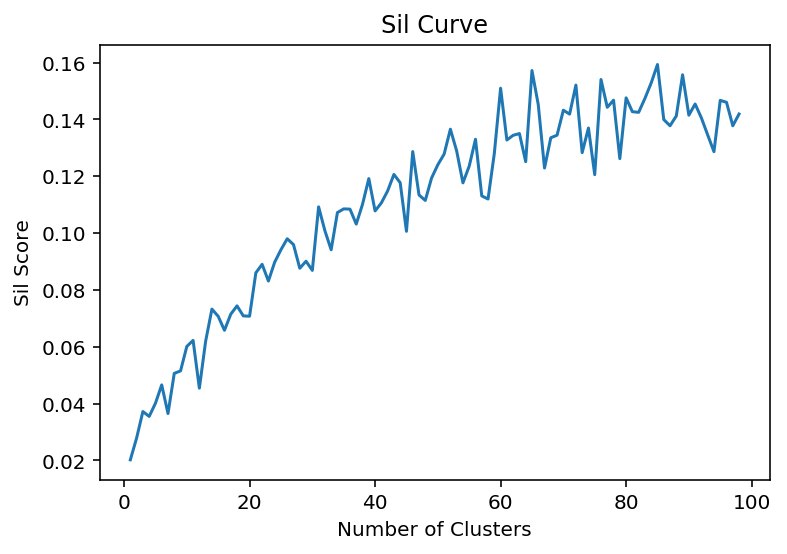

In [97]:
def score_eval_kmeans_elbow(data_to_cluster, kmeans_output):
    
    score = [kmeans_output[i].fit(data_to_cluster).score(data_to_cluster) for i in range(len(kmeans_output))]
    
    print('Number of Scores to evaluate', len(score))
    
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')

    plt.show()
    
def score_eval_kmeans_sil(data_to_cluster, kmeans_output, k_min = 1, k_max= 100):
    Nc = range(k_min, k_max-1) #range from 1 to 20 clusters
    sil_scores = [metrics.silhouette_score(data_to_cluster, kmeans_output[i].labels_, sample_size=1000) for i in range(1,len(kmeans_output))]
    max_score = 0;
    for i in range(1, len(sil_scores)):
        if max_score < sil_scores[i]:
            max_score = sil_scores[i]
            best_cluster = i

#     print(len(sil_scores))        
            
    print('Cluster (k) number with largest Coefficient:',best_cluster)
    
    plt.plot(Nc,sil_scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sil Score')
    plt.title('Sil Curve')

    plt.show()
    
    return best_cluster


# score_eval_kmeans_elbow(vector_data, kmeans_output)

kmeans_k_value = score_eval_kmeans_sil(vector_data, kmeans_output)

## Cluster Evaluation
The following section will evaluate the selected k for clustering

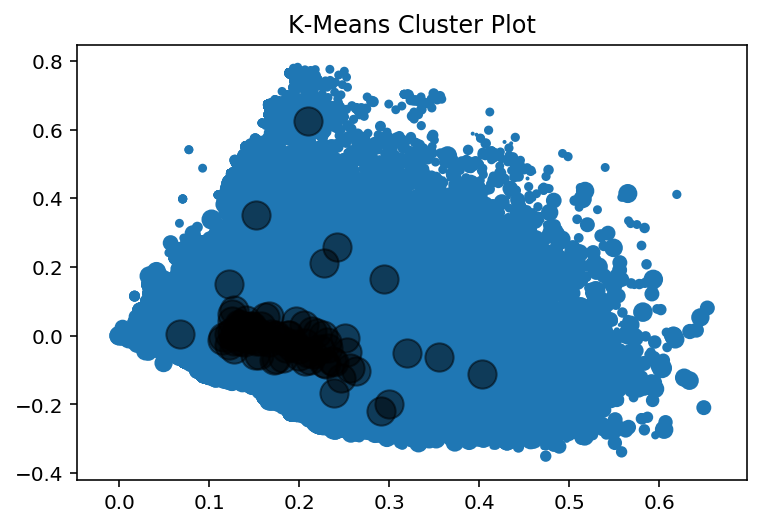

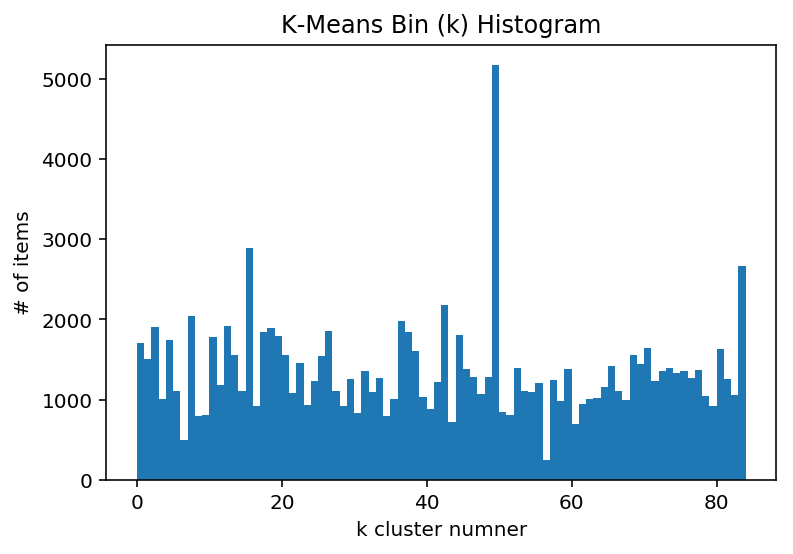

In [98]:
def kmeans_cluster_eval(Xnew, kmeans, cluster_num):
     
#     pca = PCA(n_components=1).fit(Xnew)
#     pca_2d = pca.transform(Xnew)
    
    y_kmeans = kmeans[cluster_num].predict(Xnew)
    plt.scatter(Xnew[:, 0], Xnew[:, 1], s=y_kmeans, cmap='viridis')

    centers = kmeans[cluster_num].cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.xlabel('')
    plt.ylabel('')
    plt.title('K-Means Cluster Plot')
    plt.show()
    
    plt.hist(kmeans_output[kmeans_k_value].labels_, bins=kmeans_k_value)
    plt.title('K-Means Bin (k) Histogram')
    plt.xlabel('k cluster numner')
    plt.ylabel('# of items')
    plt.show()
    
kmeans_cluster_eval(vector_data, kmeans_output, kmeans_k_value)

In [108]:
def kmeans_tfidf_viz(vector_data, kmeans, cluster_num):
    tfs_reduced = TruncatedSVD(n_components=cluster_num, random_state=0).fit_transform(vector_data)
    tfs_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfs_reduced)
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes()
    plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x", c = km.labels_)
    plt.show()
    
kmeans_tfidf_viz(vector_data,kmeans_output,kmeans_k_value) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 113865 samples in 1.017s...
[t-SNE] Computed neighbors for 113865 samples in 2419.528s...
[t-SNE] Computed conditional probabilities for sample 1000 / 113865
[t-SNE] Computed conditional probabilities for sample 2000 / 113865
[t-SNE] Computed conditional probabilities for sample 3000 / 113865
[t-SNE] Computed conditional probabilities for sample 4000 / 113865
[t-SNE] Computed conditional probabilities for sample 5000 / 113865
[t-SNE] Computed conditional probabilities for sample 6000 / 113865
[t-SNE] Computed conditional probabilities for sample 7000 / 113865
[t-SNE] Computed conditional probabilities for sample 8000 / 113865
[t-SNE] Computed conditional probabilities for sample 9000 / 113865
[t-SNE] Computed conditional probabilities for sample 10000 / 113865
[t-SNE] Computed conditional probabilities for sample 11000 / 113865
[t-SNE] Computed conditional probabilities for sample 12000 / 113865
[t-SNE] Computed conditional pro

KeyboardInterrupt: 

## Cluster Terms Extraction
The following section extracts the cluster terms for each of the clusters generated, and then creates a new dataset for manual inspect and completion.

Note: This stage of work requires manual intervention (e.g. Open the cluster terms document in Excel and manually assign names/labels to the clusters based on the terms).

In [151]:
def kmeans_cluster_terms(kmeans,cluster_num, vectorizer, svd):
    cluster_terms = []
    print("Top terms per cluster:")
    # order_centroids = kmeans[20].cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()

    original_space_centroids = svd.inverse_transform(kmeans[cluster_num].cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    print(order_centroids[10].shape)
    for i in range(0,cluster_num):
        #print("Cluster %s:" % i),
        words = ''
        for ind in order_centroids[i, :10]:
            words = words + ' ' + terms[ind]
            #print(' %s' % terms[ind]),
        #print(words)
        cluster_terms.append(words)

    blanks = []    
    for x in range(0,cluster_num):
        blanks.append("")
    
    clusterids = list(range(0,cluster_num))
    
    cluster_terms = pd.DataFrame({'terms': cluster_terms, 'ClusterIntent': blanks, 'ClusterId': clusterids})      

    print(cluster_terms.head(5))
    
    return cluster_terms

        
cluster_terms = kmeans_cluster_terms(kmeans_output, kmeans_k_value, vectorizer, svd)


filename_cluster_terms = 'cluster_terms.csv'
save_csv(PATH_TMP_DATA, filename, cluster_terms)

Top terms per cluster:
(51591,)
   ClusterId ClusterIntent                                              terms
0          0                 sim card new credit activ chang celcom hello ...
1          1                 check number pls celcom balanc hi outstand st...
2          2                 4g bar 3g connect work area coverag signal ok...
3          3                 receiv messag statement port updat got mobil ...
4          4                 problem solv celcom line face fix hi got than...
Saving Dataframe to CSV


## Update Dataframe with Cluster Ids

The existing dataframe needs to be updated with the new clusterids

In [118]:
def assign_clusterids(data_df, kmeans_output, kmeans_k_value):
    data_df['cluster'] = ''
    cluster_data_new = pd.DataFrame(
        {'message': data_df['message'],
         'clusterID': kmeans_output[kmeans_k_value].labels_,
        })
    print(cluster_data_new.head(5))
    return cluster_data_new

data_cluster_df = assign_clusterids(data_df, kmeans_output, kmeans_k_value)

   clusterID                                            message
2          5  My no 0187777773 was being charged by Singtel-...
3         10  Hi Celcom my service number is 0192662694. How...
4         19  Hi Celcom my name is Low Ming Wee and last 4 d...
5         14  Pls assist to cancel my auto billing for servi...
6         26                 Both also under my account. Thanks


## Save/Load Checkpoint 

In [63]:
filename = 'data_df_post_lang_filtering_post_clustering.p'
#save_object(PATH_TMP_DATA, filename, data_cluster_df)

#uncomment this line if you require loading an previoulsy saved object!
data_df = load_object(PATH_TMP_DATA, filename)

Attempting to Load Object


UnpicklingError: unpickling stack underflow

<a id='part_labelling'></a>

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Manual Labelling of Cluster Intent Labels

In the following section manual editing of the saved CSV file is required.

- A ClusterIntent Label needs to be assigned to each of the clusters
- If the clusters do not seem unique enough (e.g. overlap between terms), 
    - reduce the number of clusters (k)
    - more filtering on text is required

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Update Original Dataframe with New Cluster Intent Labels 

Loading Dataframe From CSV


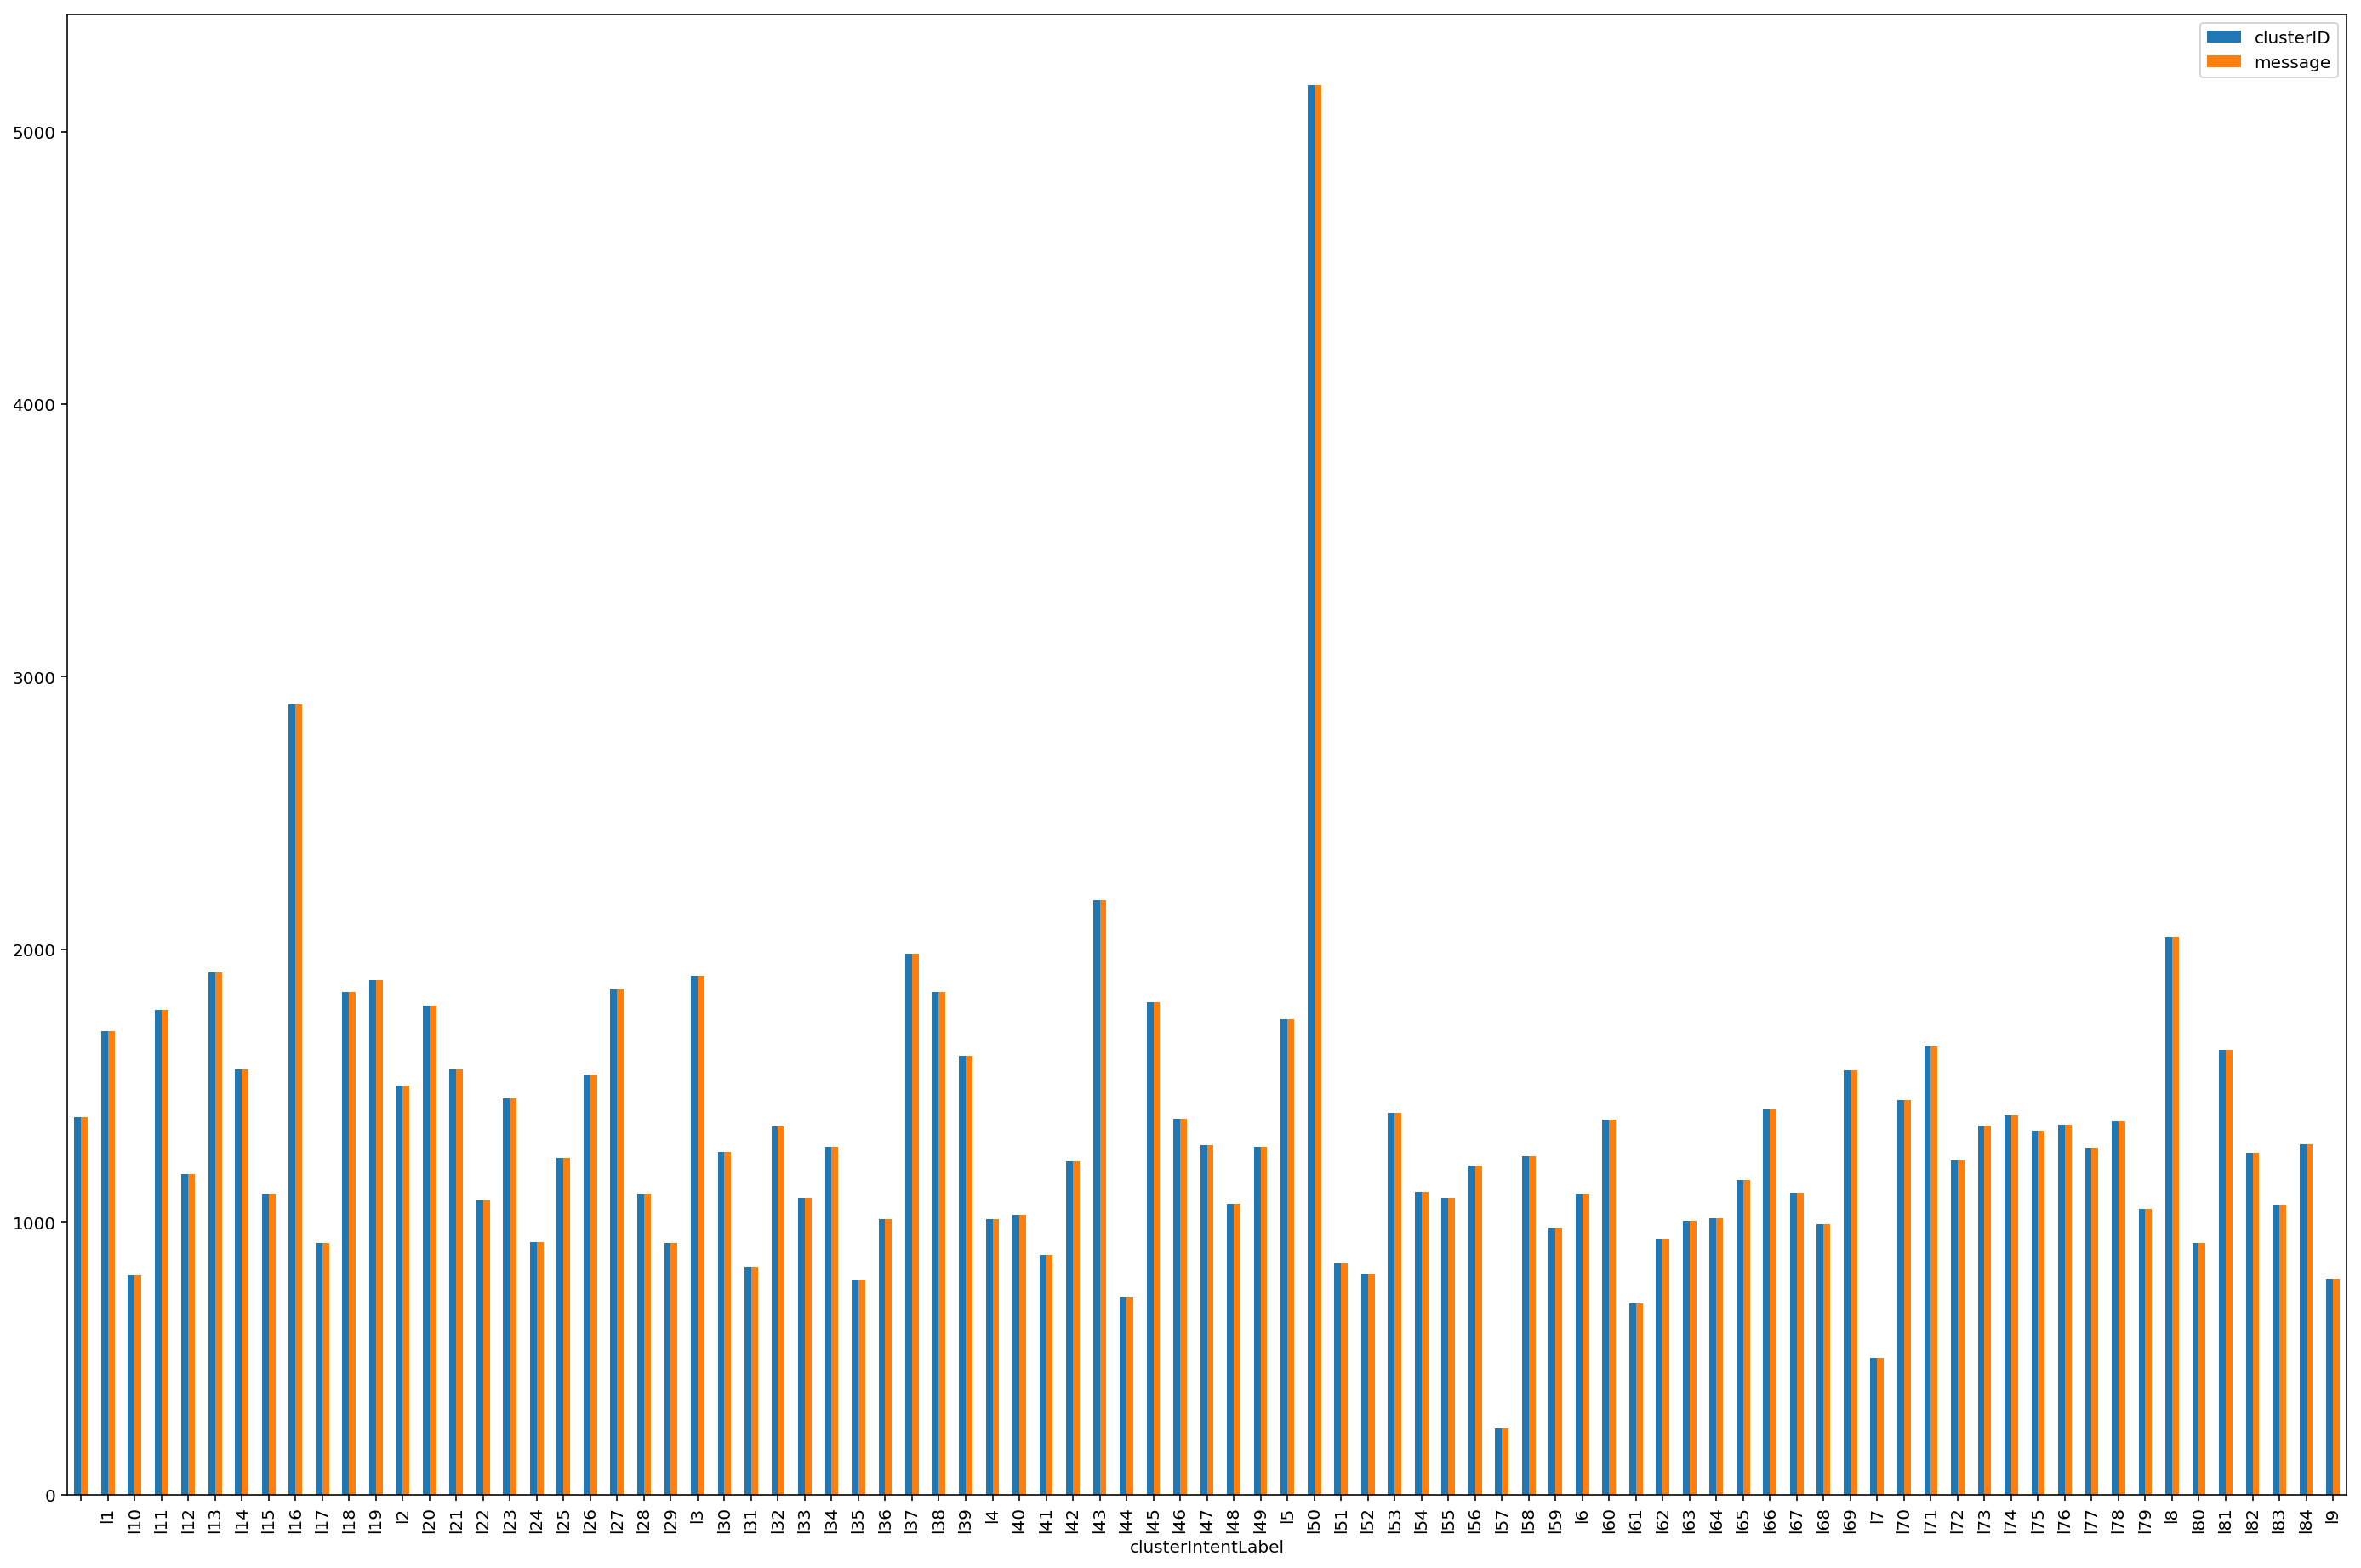

Saving Dataframe to CSV


AttributeError: 'str' object has no attribute 'to_csv'

In [170]:
def update_dataframe_with_cluster_labels(data_df, filename_cluster_terms):

    #first we need to cluster terms document
    cluster_names_df = load_csv(PATH_TMP_DATA, filename_cluster_terms)
    
    #create a unique mapping of id to name
    col_cluster_id = 'ClusterId'
    col_cluster_intent = 'ClusterIntent'

    cluster_names_map = {}

    for idx, row in cluster_names_df.iterrows():
        try:
            cus_id = row[col_cluster_id]
            cus_intent  = row[col_cluster_intent]
            cluster_names_map[cus_id] = cus_intent
        except:
            pass
        
    data_df['clusterIntentLabel'] = ""
    
    for idx, row in data_df.iterrows():
        try:
            data_df.loc[idx, 'clusterIntentLabel'] = cluster_names_map[row['clusterID']]
        except Exception as e:
            pass
    
#     print(data_df.groupby('clusterIntentLabel').count())
    data_df.groupby('clusterIntentLabel').count().plot(kind='bar', figsize = (24,16))
    plt.show()
    
    return data_df

data_df_with_labels = update_dataframe_with_cluster_labels(data_cluster_df, filename_cluster_terms)


filename_data_df_with_labels = 'data_labelled.csv'
save_csv(PATH_TMP_DATA, filename_data_df_with_labels, data_df_with_labels)

## Save/Load Checkpoint 

In [10]:
filename = 'data_df_post_lang_filtering_post_clustering_with_labels.p'
#save_object(PATH_TMP_DATA, filename, data_df_with_labels)

#uncomment this line if you require loading an previoulsy saved object!
data_df_with_labels = load_object(PATH_TMP_DATA, filename)

Attempting to Load Object
Load complete


## Notes Checkpoint

We're now at a point where we have a labelled dataset, which has been constructed using a mix of NLP, Clustering, and Manual intervention.

The next step is to train a ML model to learn how to understand and predict the different classes (labels) from our new data 


## =========================================================================
## =========================================================================

<a id='part_modelling'></a>


# Part 4. Modelling

In the following section, we will take the existing labelled data, and fit a machine learning model to predict the different classes within the dataset.

To do this we need to consider the following:

- The number of classes - The number of labels/classes we're going to predict will directly impact the type of ML algorithm we will use (multi-label classification). If we go with the One Vs. All, then we are building a classifier for each of the labels, and then performing statistical significance testing against each other classifiers. Hence the complexity increases
- The number of samples per class - Imbalance between classes can cause over or underrepresentation, which has a direct impact on the fitting of the model for a specific class.

## Clean and Prepare Data for Machine Learning

In [11]:
def clean_data_for_ml_dataset(data_df):
    
    #first we want to remove all rows where bbales are unknwon
    for idx, row in data_df.iterrows():
        try:
            message  = row['message']
            intent = row['clusterIntentLabel']
#             words = message.split(' ')
            if ('unknown' in intent.lower()):
                data_df = data_df.drop(data_df.index[idx])
                #print('float')
        except:
            pass
    
    return data_df

data_df_ml = clean_data_for_ml_dataset(data_df_with_labels)
    

## Create Train/Test Data for Machine Learning 

In [50]:
def create_test_train_datasets(data_df, VALIDATION_SPLIT= 0.2):
    
    #first let's create our features and targets
    labels = data_df['clusterIntentLabel'].astype('U')
    X = data_df['message'].str.lower()
    Y = labels
    
    print('Creating Unique set of Labels for Encoding Purposes')
    number_of_classes = len(np.unique(labels))
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    print(encoded_Y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    print('Number of labels ',dummy_y.shape[1])
    
    unqiue_words = {}
    #now we need to encode the chat messages
    #get max length of a message:
    max_length = 0;
    for msg in X:
        try:
            if len(msg) > max_length:
                max_length = len(msg)
        except:
            pass
        try:
            words = msg.split(' ')
            for wrd in words:
                unqiue_words[wrd] = True
        except:
            pass
    print('Maximum Length of Message {0}, and total number of unique words {1}'.format(max_length, len(unqiue_words)))
    vocab_size = len(unqiue_words)
    encoded_docs = [one_hot(str(d), vocab_size) for d in X]

    # pad documents to a max length of 4 words
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    print(len(padded_docs))
    
    
    #split data

    nb_validation_samples = int(VALIDATION_SPLIT * X.shape[0])
    X_train = padded_docs[:-nb_validation_samples]
    Y_train = dummy_y[:-nb_validation_samples]
    X_val = padded_docs[-nb_validation_samples:]
    Y_val = dummy_y[-nb_validation_samples:]
    
    return X_train, X_val, Y_train, Y_val, vocab_size, max_length, number_of_classes, X, labels
    
X_train, X_val, Y_train, Y_val, vocab_size, max_length, number_of_classes, X, labels = create_test_train_datasets(data_df_ml)

Creating Unique set of Labels for Encoding Purposes
[56  3 13 ... 21 28 44]
Number of labels  85
Maximum Length of Message 4676, and total number of unique words 81941
113865


## Define Neural Network for Modelling

As we're trying to classify labels in a dataset which was derviced using an unsupervised learning technique, using modelling which can fit to the underlying structure of the data is best suited.

We could try more tradtional ML Multi-label approaches, however, ANN tend to perform better with text classification tasks, as long as overfitting is managed.

More reading can be found here:

- https://machinelearnings.co/text-classification-using-neural-networks-f5cd7b8765c6


For our Neural Network, we are going to use the following Architecture:

- Embedded layer which is the size of the unique vocab found in the dataset 
- 3 fully connected laters, which are bound by the relu activation functon.
- Output later which has the same shape as the number of classes/labels in the dataset

In [13]:
def create_model(vocab_size, max_length, number_of_classes):
    from keras import optimizers


    model = Sequential()
    model.add(Embedding(vocab_size, 8, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(512,  activation='relu'))
    model.add(Dense(256,  activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(64,  activation='relu'))
    model.add(Dense(number_of_classes,  activation='softmax'))
    # compile the model

    ##only use if pre-trained
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    # summarize the model
    model.summary()
    return model 

model = create_model(vocab_size, max_length, number_of_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4676, 8)           655528    
_________________________________________________________________
flatten_1 (Flatten)          (None, 37408)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               19153408  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
__________

## Train Neural Network

In [19]:
model_checkpoints_filename = 'Celcom-Simple-DNN-best-weights-english-24-classes-bal.hdf5'

def train_model(model, X_train, X_val, Y_train, Y_val, model_checkpoints_filename):


    checkpoint = ModelCheckpoint(model_checkpoints_filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), nb_epoch=10, batch_size=20, callbacks=callbacks_list, verbose=2)
    
    return model, history

model, history = train_model(model, X_train, X_val, Y_train, Y_val, model_checkpoints_filename)

C:\Users\ratinati\AppData\Local\Continuum\anaconda2\envs\gpu-tf\lib\site-packages\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91092 samples, validate on 22773 samples
Epoch 1/10


KeyboardInterrupt: 

## Load the most accuracte set of weights evaluate

Best Model Accuracy: 66.59
Lowest Loss: 1.52
22688/22773 [============================>.] - ETA: 0s

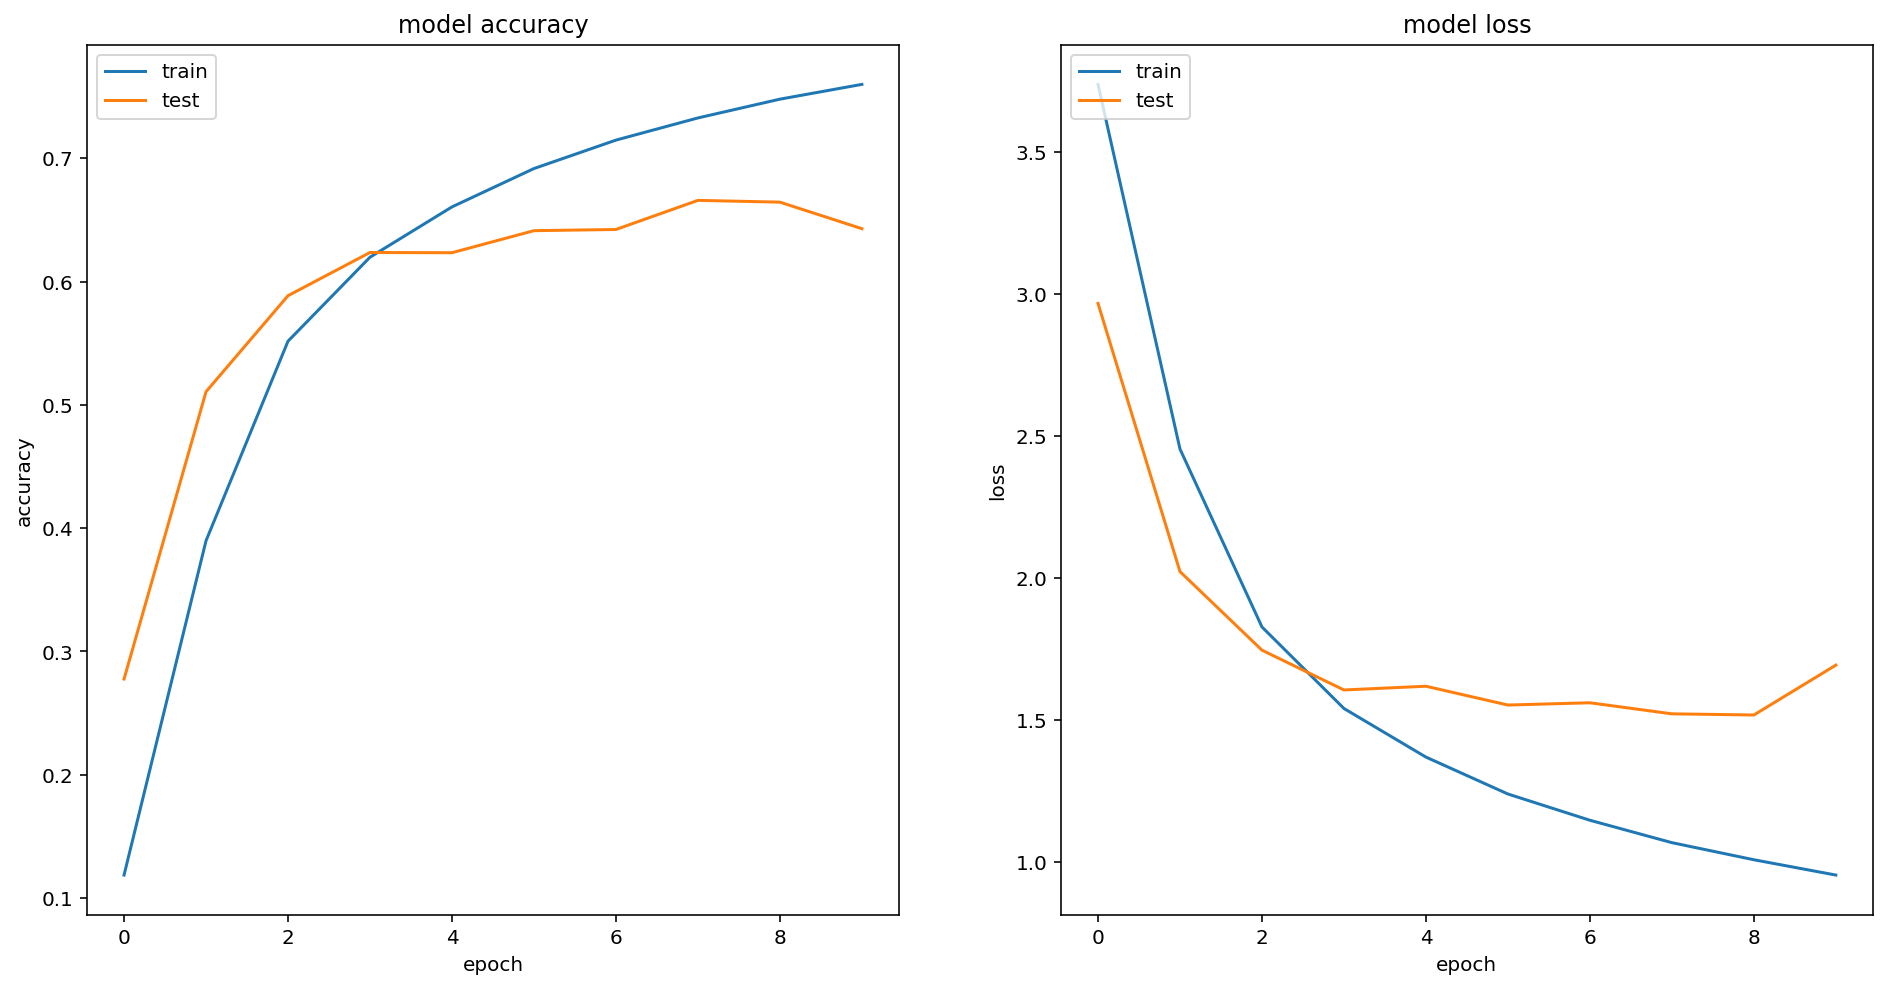

In [36]:
def load_most_accuracte_evaluate(model, history, model_checkpoints_filename, X_val, Y_val, labels):

    model.load_weights(model_checkpoints_filename)
    loss, accuracy = model.evaluate(X_val, Y_val, verbose=2)
    print('Best Model Accuracy: %.2f' % (accuracy*100))
    print('Lowest Loss: %.2f' % (loss))
    
    #Training Accuracy
    # summarize history for accuracy
    plt.figure(figsize = (16,8))
    
    ##classification report
    preds = model.predict_classes(X_val)
    true_labels = np.unique(labels)
    print('Classification Report For {0} Classes:'.format(len(true_labels)))
    true_k_labels = sorted(true_labels) # Sorting them
    y_preds = np_utils.to_categorical(preds)
    print(classification_report(y_true=Y_val, y_pred=y_preds, target_names=true_k_labels))
    

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    #Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
 
    return model
    
model = load_most_accuracte_evaluate(model, history,model_checkpoints_filename, X_val, Y_val, labels)

## Test Model Predictions With Known Data

In the following section, we examine the predictive capabilities of the model

In [57]:
def predict_label_from_test_data(idx, model, vocab_size, max_length, X, labels):
    
    true_labels = np.unique(labels)
    true_k_labels = sorted(true_labels) # Sorting them

    
    msg = X.tolist()[idx]
    real_label = labels.tolist()[idx]
    print('Message to predict Label:', msg)
    print('Label of Message:', real_label)
    #ENCODE AND PAD
    encoded_doc = [one_hot(str(msg), vocab_size)]
    padded_doc = pad_sequences(encoded_doc, maxlen=max_length, padding='post')
    y_prob = model.predict(padded_doc, verbose=2) 
    y_classes = y_prob.argmax(axis=-1)
    print('Predicted Label: ',true_k_labels[y_classes[0]])
    return true_k_labels[y_classes[0]]



predicted_label = predict_label_from_test_data(27000, model, vocab_size, max_length, X, labels)
  

Message to predict Label: can i knew how i fix this problem
Label of Message: l5
Predicted Label:  l5


## Test Model with New/Unseen Data

The following method allows can be used to evaluate the model with new unseen data. 

To use, enter a new message, and see what label the model predicts!

In [62]:
def predict_label_with_unseen_data(message, model, vocab_size, max_length,labels):
    
    true_labels = np.unique(labels)
    true_k_labels = sorted(true_labels) # Sorting them

    
    msg = message

    print('Message to predict Label:', msg)
    #ENCODE AND PAD
    encoded_doc = [one_hot(str(msg), vocab_size)]
    padded_doc = pad_sequences(encoded_doc, maxlen=max_length, padding='post')
    y_prob = model.predict(padded_doc, verbose=2) 
    y_classes = y_prob.argmax(axis=-1)
    print('Predicted Label: ',true_k_labels[y_classes[0]])
    
    return true_k_labels[y_classes[0]]



message_to_test = 'Need help'

predicted_label = predict_label_with_unseen_data(message_to_test, model, vocab_size, max_length, labels)

Message to predict Label: Need help
Predicted Label:  l19


## =========================================================================
## =========================================================================

# Recap and Next Steps

The purpose of this tutorial was to demonstrate how to combine the use of unstructred clustering techniques with machine learning approaches to build a labelled set of documents for different classification tasks.

In this notebook, the following topics have been covered:

- Introduction to Natural Language Processing (Cleansing and Transforming)
- Unsupervised Clusetering Using K-Means on Text Data
- Manual Inspection and Assignment of Labels to clustered textual data
- Fitting a Neural Network to predict the class/label of a given set of similar documents (in this example, strings)


## Next Steps

There are several steps required to operationalize this code:

- Define a scalable strategy to label the outpuut of the clusters, this could involve developing a more intuative interface for labelling, or using concepts such as Topic Modelling (LDA)
- Improving the ANN model architecture to support a richer approach to word embedding (RNN approach could be used)
- Operationalize the code by wrapping the functions into class structure
 
